# Example Notebook to showcasing how we interact with JTReaders

### Bookkeeping of all existing readers: `readers.py`

In [1]:
import jack.readers as readers

print("Existing models:\n{}".format(", ".join(readers.readers.keys())))

Existing models:
dam_snli_reader, fastqa_reader, esim_snli_reader, bidaf_reader, complex_reader, cbow_xqa_reader, cbilstm_snli_reader, modelf_reader, transe_reader, distmult_reader


### Load test data

In [3]:
# Loaded some test data to work on
# This loads train, dev, and test data of sizes (2k, 1k, 1k)
import os
from jack.io.load import load_jack


class TestDatasets:
    @staticmethod
    def generate():
        snli_path, snli_data = '../tests/test_data/SNLI/', []
        splits = ['train.json', 'dev.json', 'test.json']
        for split in splits:
            path = os.path.join(snli_path, split)
            snli_data.append(load_jack(path))

        return snli_data

train_set, dev_set, test_set = TestDatasets.generate()

### Create a reader

In [13]:
from jack.core import SharedResources
from jack.util.vocab import Vocab

# Create example reader with a basic config
embedding_dim = 128
hidden_dim = 128
config = {"batch_size": 128, "repr_dim": hidden_dim, "repr_dim_input": embedding_dim, 'dropout' : 0.1}
svac = SharedResources(Vocab(), config)

reader = readers.readers["dam_snli_reader"](svac)

TypeError: dam_snli_reader() got an unexpected keyword argument 'output_module'

### Add hooks

In [6]:
# We create hooks which keep track of the metrics such as the loss
# We also create a classification metric monitoring hook for our model
from jack.util.hooks import LossHook

hooks = [LossHook(reader, iter_interval=10),
         readers.eval_hooks['dam_snli_reader'](reader, dev_set, iter_interval=25, batch_size=32)]

### Initialise optimiser

In [7]:
# Here we initialise our optimiser
# we choose Adam with standard momentum values and learning rate 0.001
import tensorflow as tf

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate)

### Train reader

In [8]:
# Lets train the reader on the CPU for 2 epochs
reader.train(optimizer, train_set, hooks=hooks, max_epochs=2, batch_size=32)

INFO:jack.core.reader:Start training...
INFO:jack.util.hooks:Epoch 1	Iter 10	train loss 1.0986429929733277
INFO:jack.util.hooks:Epoch 1	Iter 20	train loss 1.0985550165176392
INFO:jack.util.hooks:Started evaluation ClassificationEvalHook


/home/pasquale/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO:jack.util.hooks:Epoch 1	Iter 25	total 1000	Accuracy: 0.336	F1_macro: 0.167	ClassificationEvalHook
INFO:jack.util.hooks:Epoch 1	Iter 30	train loss 1.0991007208824157
INFO:jack.util.hooks:Epoch 1	Iter 40	train loss 1.0988498330116272
INFO:jack.util.hooks:Epoch 1	Iter 50	train loss 1.0985594511032104
INFO:jack.util.hooks:Started evaluation ClassificationEvalHook
INFO:jack.util.hooks:Epoch 1	Iter 50	total 1000	Accuracy: 0.336	F1_macro: 0.167	ClassificationEvalHook
INFO:jack.util.hooks:Epoch 1	Iter 60	train loss 1.0987383842468261
INFO:jack.util.hooks:Started evaluation ClassificationEvalHook
INFO:jack.util.hooks:Epoch 1	Iter 63	total 1000	Accuracy: 0.360	F1_macro: 0.274	ClassificationEvalHook
INFO:jack.util.hooks:Epoch 2	Iter 70	train loss 1.0878629446029664
INFO:jack.util.hooks:Started evaluation ClassificationEvalHook
INFO:jack.util.hooks:Epoch 2	Iter 75	total 1000	Accuracy: 0.361	F1_macro: 0.230	ClassificationEvalHook
INFO:jack.util.hooks:Epoch 2	Iter 80	train loss 1.12328482866287

### Plotting the results

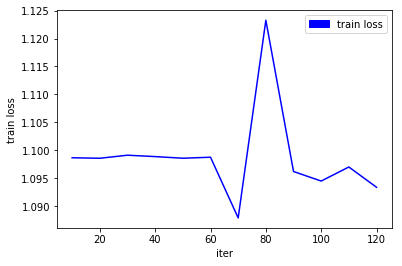

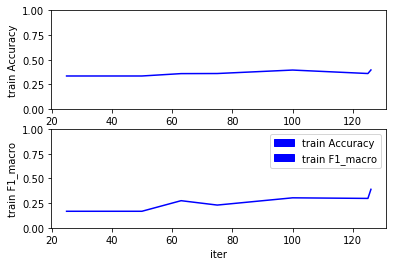

In [9]:
# This plots the loss
hooks[0].plot()
# This plots the F1 (macro) score and accuracy between 0 and 1
hooks[1].plot(ylim=[0.0, 1.0])